In [1]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
(path/'train').ls()

(#2) [Path('C:/Users/Melvi/.fastai/data/mnist_sample/train/3'),Path('C:/Users/Melvi/.fastai/data/mnist_sample/train/7')]

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [5]:
im3 = Image.open(threes[1])
im3

In [6]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [7]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(seven_tensors), len(three_tensors)

(6265, 6131)

<Axes: >

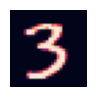

In [8]:
show_image(three_tensors[1])

In [9]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [10]:
print("Rank:", len(stacked_threes.shape), "= number of axes")

Rank: 3 = number of axes


<Axes: >

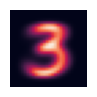

In [11]:
mean3 = stacked_threes.mean(dim=0)
show_image(mean3)

<Axes: >

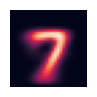

In [12]:
mean7 = stacked_sevens.mean(dim=0)
show_image(mean7)

<Axes: >

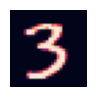

In [13]:
a_3 = stacked_threes[1]
show_image(a_3)

In [14]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [15]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [16]:
F.l1_loss(a_3,mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [17]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls().sorted()]).float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls().sorted()]).float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [18]:
def mnist_distance(a, b):
    return (a-b).abs().mean([-1, -2])

In [19]:
mnist_distance(a_3, mean3)

tensor(0.1114)

In [20]:
mnist_distance(valid_3_tens, mean3)

tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

In [21]:
def is_3(x):
    return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [22]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [23]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()
accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [24]:
train_x = torch.cat((stacked_threes, stacked_sevens)).view(-1, 28 * 28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [25]:
dset = list(zip(train_x, train_y))
valid_x = torch.cat((valid_3_tens, valid_7_tens)).view(-1, 28 * 28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [26]:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()

weights = init_params((28*28, 1))
bias = init_params(1)
weights.shape

torch.Size([784, 1])

In [27]:
(train_x[0]*weights.T).sum() + bias

tensor([-1.2459], grad_fn=<AddBackward0>)

In [28]:
def linear1(xb):
    return xb@weights + bias

In [29]:
preds = linear1(train_x)
preds.shape, preds[0]

(torch.Size([12396, 1]), tensor([-1.2459], grad_fn=<SelectBackward0>))

In [30]:
corrects = (preds>0.0).float() == train_y
corrects.float().mean().item()

0.4267505705356598

In [31]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

<Axes: xlabel='None', ylabel='None'>

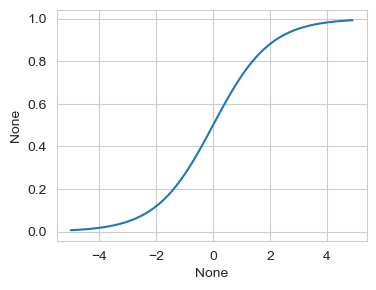

In [32]:
x = torch.arange(-5, 5, 0.1)
plt.figure(figsize=(4,3))
sns.lineplot(x=x, y=torch.sigmoid(x))

In [33]:
weights = init_params((28*28, 1))
bias = init_params(1)

dl = DataLoader(dset, batch_size=256, shuffle=True)
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [34]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [35]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [36]:
preds = linear1(batch)
print(preds)

tensor([[10.1536],
        [14.7960],
        [ 3.6628],
        [14.2396]], grad_fn=<AddBackward0>)


In [37]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.0063, grad_fn=<MeanBackward0>)

In [38]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0009), tensor([-0.0061]))

In [39]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [40]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0018), tensor([-0.0122]))

In [41]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [42]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [43]:
z = (preds>0.5).float() == train_y[:4]
print(z)

tensor([[True],
        [True],
        [True],
        [True]])


In [44]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [45]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [46]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [47]:
validate_epoch(linear1)

0.6143

In [48]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.9152

In [49]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.9388 0.9481 0.9525 0.9569 0.9608 0.9623 0.9648 0.9672 0.9682 0.9687 0.9687 0.9692 0.9701 0.9706 0.9711 0.9711 0.9716 0.9721 0.9745 0.9741 

# Optimizer

In [50]:
linear_model = nn.Linear(28*28, 1)
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [51]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad*self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [52]:
opt = BasicOptim(linear_model.parameters(), lr)

In [53]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [54]:
validate_epoch(linear_model)

0.7622

In [55]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [56]:
train_model(linear_model, 20)

0.9711 0.9765 0.976 0.978 0.978 0.9795 0.9795 0.9795 0.9799 0.9799 0.9799 0.9809 0.9809 0.9809 0.9819 0.9814 0.9819 0.9819 0.9819 0.9819 

In [57]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.9711 0.9765 0.9775 0.978 0.979 0.9799 0.979 0.9799 0.9799 0.9804 0.9809 0.9814 0.9814 0.9829 0.9814 0.9829 0.9819 0.9824 0.9824 0.9824 

In [58]:
dls = DataLoaders(dl, valid_dl)

In [59]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [60]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.060249,0.041077,0.970559,00:00
1,0.040640,0.035091,0.975466,00:00
2,0.032497,0.032098,0.976448,00:00
3,0.028295,0.029757,0.976938,00:00
4,0.025757,0.028321,0.978410,00:00
5,0.023807,0.026956,0.978410,00:00
6,0.022446,0.026718,0.978901,00:00
7,0.021572,0.025515,0.979882,00:00
8,0.020702,0.025642,0.979882,00:00
9,0.020209,0.024406,0.980373,00:00


In [96]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
)

In [97]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.207773,0.086326,0.962709,00:00
1,0.102356,0.053720,0.967615,00:00
2,0.064595,0.044554,0.969087,00:00
3,0.047438,0.039785,0.970559,00:00
4,0.038448,0.037086,0.970069,00:00
5,0.034360,0.035173,0.972031,00:00
6,0.030532,0.033344,0.973503,00:00
7,0.028236,0.031880,0.973994,00:00
8,0.026706,0.030957,0.974975,00:00
9,0.025811,0.029708,0.975957,00:00


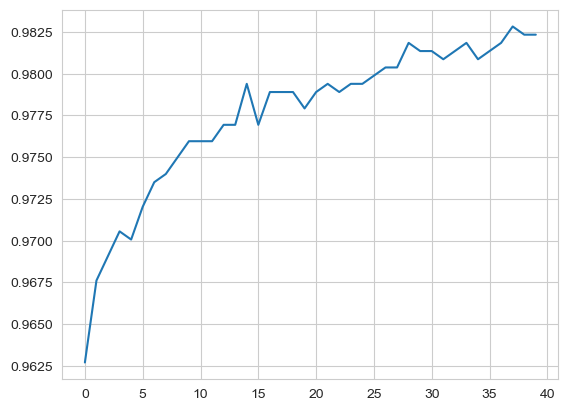

In [98]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [102]:
learn.recorder.values[-1][2]

0.98233562707901

In [104]:
dls2 = ImageDataLoaders.from_folder(path)
learn2 = cnn_learner(dls2, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn2.fit_one_cycle(1, 0.1)

C:\Users\Melvi\anaconda3\envs\p3_12_9\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,time
0,0.102897,0.010849,0.997056,00:55
